In [338]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

Get Stock Data from Yahoo Finance

In [406]:
ticker = [""]

temp = yf.download(ticker, start = "2000-01-01", end = "2025-01-01", group_by="ticker")

GSPC = temp["AAPL"].drop(['Volume'], axis = 1)

[*********************100%***********************]  1 of 1 completed


# Random Monthly buying Strategy

In [419]:
# Create a column with year-month information
GSPC['YearMonth'] = GSPC.index.to_period('M')

# Get unique months in the dataset
unique_months = GSPC['YearMonth'].unique()

# Create empty lists to store randomly selected data
random_dates = []
random_open_prices = []
random_close_prices = []

rng = np.random.RandomState(42) # So the results can be replicated

# For each month, select a random trading day
for month in unique_months:
    # Get all rows for this month
    month_data = GSPC[GSPC['YearMonth'] == month]
    
    # Select a random row
    random_row = month_data.sample(n=1, random_state = rng)
    
    # Store the information
    random_dates.append(random_row.index[0])
    random_open_prices.append(random_row['Open'].iloc[0])
    random_close_prices.append(random_row['Close'].iloc[0])

# Create DataFrame with randomly selected data
monthly_trades = pd.DataFrame({
    'Date': random_dates,
    'Open Price': random_open_prices,
    'Close Price': random_close_prices
})

# Set Date as index and sort chronologically
monthly_trades.set_index('Date', inplace=True)
monthly_trades.sort_index(inplace=True)

# Continue with the calculations
monthly_trades['Investment'] = monthly_investment
monthly_trades['Shares_Bought'] = monthly_trades['Investment'] / monthly_trades['Open Price']
monthly_trades['Cumul_Shares'] = monthly_trades['Shares_Bought'].cumsum()
monthly_trades['Cumul_Invested'] = monthly_trades['Investment'].cumsum()
monthly_trades['Portfolio Value'] = monthly_trades['Cumul_Shares'] * monthly_trades['Close Price']

monthly_trades

,Open Price,Close Price,Investment,Shares_Bought,Cumul_Shares,Cumul_Invested,Portfolio Value
Date,,,,,,,
2000-01-03,0.79,0.84,1000,1267.40,1267.40,1000,1067.34
2000-02-29,0.85,0.86,1000,1170.44,2437.85,2000,2102.32
2000-03-15,0.87,0.87,1000,1149.57,3587.41,3000,3137.53
2000-04-07,0.96,0.99,1000,1044.55,4631.96,4000,4591.23
2000-05-02,0.93,0.89,1000,1078.45,5710.41,5000,5064.10
...,...,...,...,...,...,...,...
2024-08-28,227.42,225.99,1000,4.40,205676.55,296000,46481381.52
2024-09-19,224.50,228.37,1000,4.45,205681.01,297000,46970833.50
2024-10-07,224.01,221.20,1000,4.46,205685.47,298000,45498274.88


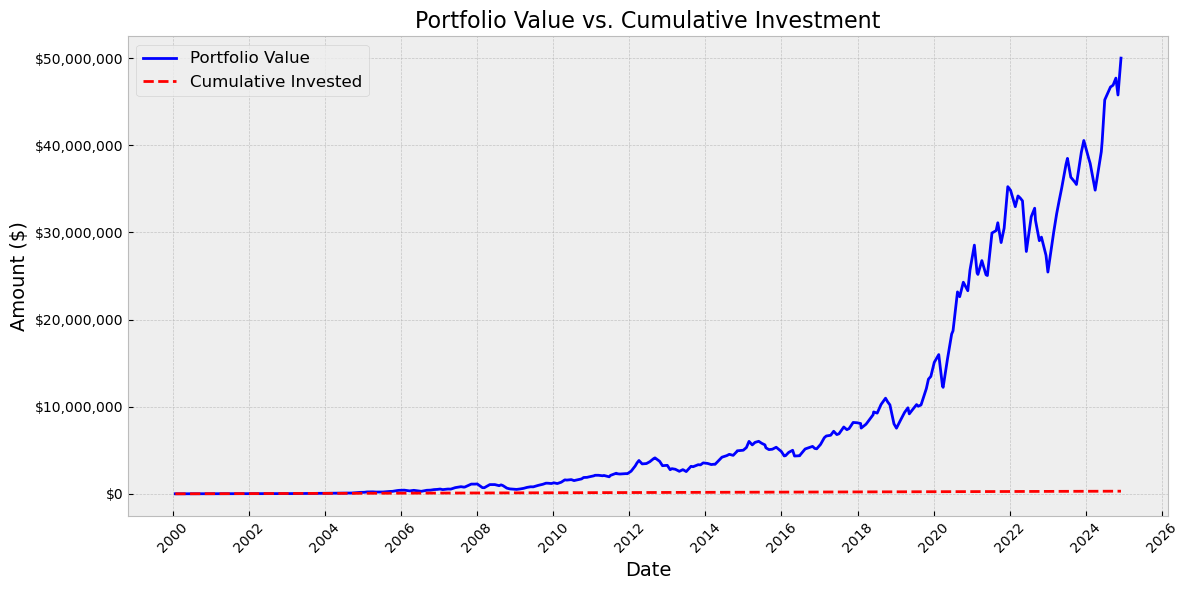

In [411]:
# Create a resampled DataFrame for plotting that shares the same index as monthly_trades
plot_data = monthly_trades[['Portfolio Value', 'Cumul_Invested']].copy()

# Now plot using plot_data which has both series with the same index
plt.figure(figsize=(12, 6))

# Plot the portfolio value
plt.plot(
    plot_data.index,
    plot_data['Portfolio Value'],
    'b-',
    linewidth=2,
    label='Portfolio Value'
)

# Plot the cumulative invested capital
plt.plot(
    plot_data.index,
    plot_data['Cumul_Invested'],
    'r--',
    linewidth=2,
    label='Cumulative Invested'
)

# Title, labels, grid
plt.title('Portfolio Value vs. Cumulative Investment', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Amount ($)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.xticks(rotation=45)

# Format y-axis to show dollar amounts
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: f"${int(x):,}")
)

# Legend
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

# SMA Crossover Strategy

In [401]:
GSPC["SMA_50"] = GSPC['Close'].rolling(window = 50).mean().dropna()
GSPC["SMA_200"] = GSPC['Close'].rolling(window = 200).mean().dropna()

# Got this section of code from https://stackoverflow.com/questions/28345261/python-and-pandas-moving-average-crossover

diff         = GSPC['SMA_50'] < GSPC['SMA_200']
diff_forward = diff.shift(1)
crossing     = np.where(diff != diff_forward)[0]

# 2) Build signals
signals = []
for i in crossing:
    if GSPC['SMA_50'].iloc[i] > GSPC['SMA_200'].iloc[i]:
        signals.append((i, 'long'))   # Golden cross → go long
    else:
        signals.append((i, 'short'))  # Death cross → go short

# 3) Backtest loop
initial_balance = 300000 # Using 300k as we invsted that same amount in the DCA Model
balance = initial_balance
equity_times = []
equity_values = []
trades = []

# Loop through each crossover 

for j in range(len(signals) - 1):
    entry_id, position = signals[j]
    exit_id, _     = signals[j + 1]
    
    entry_price = GSPC['Close'].iloc[entry_id]
    exit_price  = GSPC['Close'].iloc[exit_id]
    
    if position == 'long':
        Return = (exit_price - entry_price) / entry_price
    else:
        Return = (entry_price - exit_price) / entry_price
    
    profit = balance * Return
    balance += profit
    
    equity_times.append(GSPC.index[exit_id])
    equity_values.append(balance)
    
    trades.append({
        'Entry Date': GSPC.index[entry_id],
        'Position'      : position,
        'Entry Price': entry_price,
        'Exit Date' : GSPC.index[exit_id],
        'Exit Price': exit_price,
        'Return'    : Return * 100,
        'Balance After Trade': balance
    })

trades_df = pd.DataFrame(trades)

# Working out stats

total_trades  = len(trades_df)
wins          = trades_df['Return'] > 0
losses        = trades_df['Return'] <= 0
num_wins      = wins.sum()
num_losses    = losses.sum()
win_rate      = num_wins / total_trades * 100
avg_return    = trades_df['Return'].mean()

SMA_stats = pd.DataFrame({
    'Stats': [
        'Total Trades', 'Winning Trades', 'Losing Trades', 'Win Rate (%)',
        'Avg. Return on Trade (%)'],
    'Value': [
        total_trades,
        num_wins,
        num_losses,
        win_rate,
        avg_return,
    ]
})
SMA_stats

,Stats,Value
0,Total Trades,24.00
1,Winning Trades,11.00
2,Losing Trades,13.00
3,Win Rate (%),45.83
4,Avg. Return on Trade (%),41.87


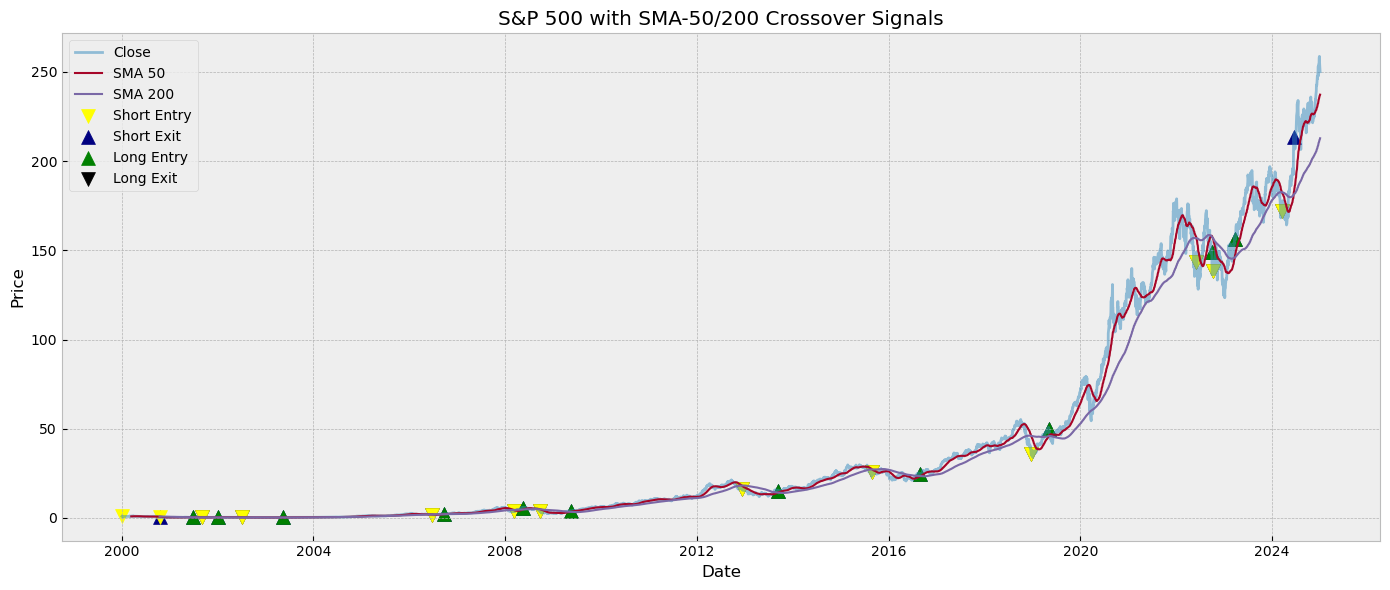

In [402]:
plt.figure(figsize=(14,6))

# 1) Plot price and SMAs
plt.plot(GSPC.index, GSPC['Close'], label='Close', alpha=0.5, linewidth=2)
plt.plot(GSPC.index, GSPC['SMA_50'], label='SMA 50', alpha=1, linewidth=1.5)
plt.plot(GSPC.index, GSPC['SMA_200'], label='SMA 200', alpha=1, linewidth=1.5)

# 2) Annotate each trade
for _, trade in trades_df.iterrows():
    entry_dt = trade['Entry Date']
    exit_dt  = trade['Exit Date']
    entry_px = trade['Entry Price']
    exit_px  = trade['Exit Price']
    pos      = trade['Position']
    
    # marker style
    if pos == 'long':
        plt.scatter(entry_dt, entry_px, marker='^', color='green', s=100, label='Long Entry')
        plt.scatter(exit_dt,  exit_px,  marker='v', color='black',   s=100, label='Long Exit')
    else:
        plt.scatter(entry_dt, entry_px, marker='v', color='yellow', s=100, label='Short Entry')
        plt.scatter(exit_dt,  exit_px,  marker='^', color='navy',   s=100, label='Short Exit')

# 3) Clean up legend (avoid duplicate labels)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')

plt.title('S&P 500 with SMA-50/200 Crossover Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

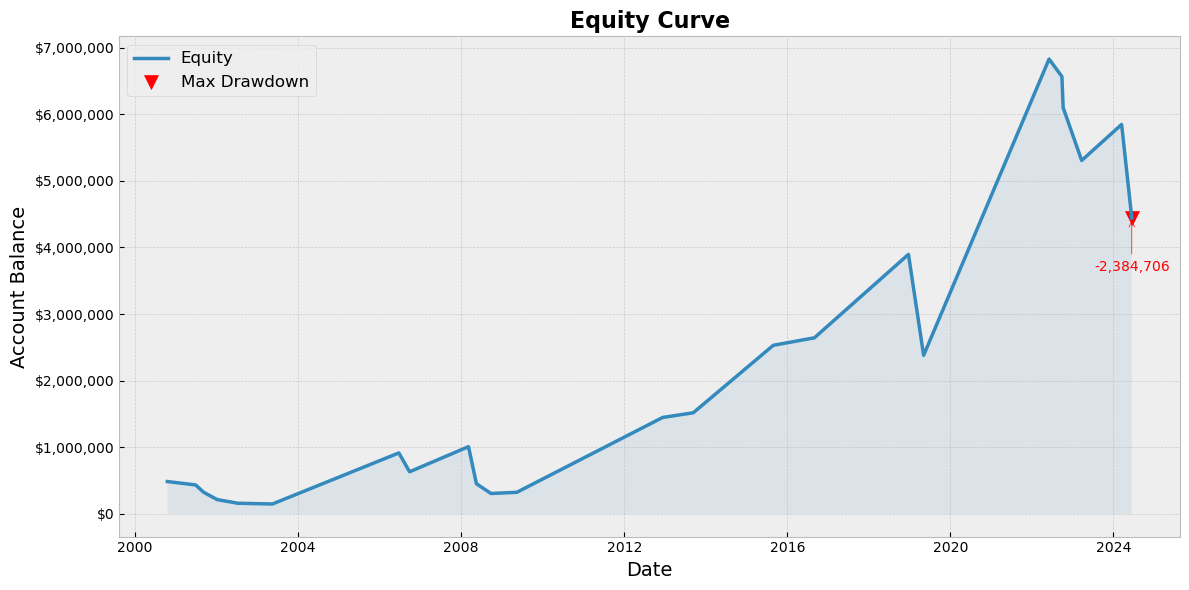

In [403]:
equity = pd.Series(equity_values, index=equity_times)

running_max = equity.cummax()
drawdowns  = equity - running_max
dd_date     = drawdowns.idxmin()
dd_val      = equity.loc[dd_date]
dd_amt      = drawdowns.min()  # negative dollar drawdown

# Formatter for dollar axis
def to_dollars(x, pos):
    return f"${x:,.0f}"

plt.figure(figsize=(12,6))

# 1) Plot equity line + fill
plt.plot(equity.index, equity.values, linewidth=2.5, label='Equity')
plt.fill_between(equity.index, equity.values, alpha=0.1)

# 2) Currency formatting on y‐axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_dollars))

# 3) Grid, title, labels
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.title('Equity Curve', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)

# 4) Highlight max drawdown
plt.scatter(dd_date, dd_val, color='red', marker='v', s=100, label='Max Drawdown')
plt.annotate(
    f"{dd_amt:,.0f}",
    xy=(dd_date, dd_val),
    xytext=(0, -30),
    textcoords="offset points",
    ha="center",
    va="top",
    fontsize=10,
    color='red',
    arrowprops=dict(arrowstyle="->", color='red',alpha = 1)
)

# 5) Legend and layout
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


In [404]:
trades_df

,Entry Date,Position,Entry Price,Exit Date,Exit Price,Return,Balance After Trade
0,2000-01-03,short,0.84,2000-10-16,0.32,61.59,484757.02
1,2000-10-16,short,0.32,2001-06-26,0.36,-10.46,434027.32
2,2001-06-26,long,0.36,2001-09-06,0.27,-25.39,323830.65
3,2001-09-06,short,0.27,2002-01-04,0.36,-33.69,214730.15
4,2002-01-04,long,0.36,2002-07-09,0.26,-26.00,158894.94
5,2002-07-09,short,0.26,2003-05-15,0.28,-6.85,148018.16
6,2003-05-15,long,0.28,2006-06-21,1.74,517.83,914504.86
7,2006-06-21,short,1.74,2006-09-25,2.28,-30.92,631745.14
8,2006-09-25,long,2.28,2008-03-06,3.64,59.64,1008540.64
9,2008-03-06,short,3.64,2008-05-16,5.65,-55.15,452355.47


# Buy the dip Strategy

<PeriodArray>
['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07',
 '2000-08', '2000-09', '2000-10',
 ...
 '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09',
 '2024-10', '2024-11', '2024-12']
Length: 300, dtype: period[M]
